In [12]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings
import os, random
from torchsummary import summary
from stage_2_models import BootstrapL2Loss, AugmentedEncoder, AugmentedDecoder, AugmentedAutoEncoder
warnings.filterwarnings('ignore')
%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [13]:
from torch.utils.data import Dataset
import imgaug.augmenters as iaa


tform = iaa.Sequential([
	#Sometimes(0.5, PerspectiveTransform(0.05)),
	#Sometimes(0.5, CropAndPad(percent=(-0.05, 0.1))),
	iaa.Sometimes(0.5, iaa.Affine(scale=(1.0, 1.2))),
	iaa.Sometimes(0.5, iaa.CoarseDropout( p=0.2, size_percent=0.05) ),
	iaa.Sometimes(0.5, iaa.GaussianBlur(1.2*np.random.rand())),
  iaa.Sometimes(0.5, iaa.Add((-25, 25), per_channel=0.3)),
  iaa.Sometimes(0.3, iaa.Invert(0.2, per_channel=True)),
  iaa.Sometimes(0.5, iaa.Multiply((0.6, 1.4), per_channel=0.5)),
  iaa.Sometimes(0.5, iaa.Multiply((0.6, 1.4))),
  iaa.Sometimes(0.5, iaa.ContrastNormalization((0.5, 2.2), per_channel=0.3))
	], random_order=False)


class Stage2Dataset(Dataset):
  def __init__(self, tless_folder, mask_folder, background_folder, mask_postfix, tform, size):

    self.dirs = []
    self.lengths = []
    self.N = 0

    for dir in os.listdir(tless_folder):
      # take the subfolders
      self.dirs.append(os.path.join(tless_folder, dir))
      self.lengths.append(len(os.listdir(os.path.join(tless_folder, dir) + "/rgb")))
      self.N += self.lengths[-1]


    self.mask_postfix = mask_postfix
    self.tless_folder = tless_folder
    self.mask_folder = mask_folder
    self.background_folder = background_folder
    self.convert_tensor = transforms.Compose([transforms.ToTensor(), transforms.Resize((128, 128))])
    self.tform = tform
    self.size = size

  # Find the correct folder and file name given index
  def find_index(self, idx):
    temp = idx
    for i in range(len(self.dirs)):
      if temp < self.lengths[i]:
        return self.dirs[i], temp
      temp -= self.lengths[i]


  def __len__(self):
    return self.N

  def __getitem__(self, idx):
    fold, file = self.find_index(idx)

    img = Image.open(os.path.join(fold, "rgb") + "/" + str(file).zfill(6) + ".png").resize(self.size)
    back_img = Image.open(self.background_folder + str(random.choice(os.listdir(self.background_folder)))).resize(self.size)
    mask_img = Image.open(os.path.join(fold, "mask") + "/" + str(file).zfill(6) + mask_postfix + ".png").resize(self.size)

    aug_img = Image.composite(img, back_img, mask_img)

    image = self.convert_tensor(self.tform(images=np.array(aug_img)))
    return image, self.convert_tensor(img)

In [14]:
from torchvision import datasets, transforms
rgb_folder = "/home/umut/Desktop/501/dataset/tless_train_primesense/train_primesense"
mask_folder = "/home/ege/src/CENG501/tless/train_primesense/000001/mask/"
background_folder = "/home/umut/Desktop/501/dataset/VOCtrainval_11-May-2012/VOCdevkit/VOC2012/JPEGImages/"
mask_postfix = "_000000"

img_files = Stage2Dataset(rgb_folder, mask_folder, background_folder, mask_postfix, tform, (128,128))
dataloader = torch.utils.data.DataLoader(img_files, batch_size=32, shuffle=True, num_workers=10)



In [15]:
x = torch.rand((4,5,5,3))
y = torch.rand_like(x)

loss_test = BootstrapL2Loss()
loss_test(x,y)

tensor(0.6138)

In [16]:
aee = AugmentedEncoder(128, 3, 64)
aee.to(device)
summary(aee, input_size=(3, 64, 64), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 32, 32]           9,728
            Conv2d-2          [-1, 256, 16, 16]         819,456
            Conv2d-3            [-1, 256, 8, 8]       1,638,656
            Conv2d-4            [-1, 512, 4, 4]       3,277,312
            Linear-5                  [-1, 128]       1,048,704
Total params: 6,793,856
Trainable params: 6,793,856
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 1.69
Params size (MB): 25.92
Estimated Total Size (MB): 27.65
----------------------------------------------------------------


In [17]:
aed = AugmentedDecoder(128,1, 64)
aed.to(device)
summary(aed, input_size=(128,), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 8192]       1,056,768
            Conv2d-2            [-1, 256, 8, 8]       3,277,056
            Conv2d-3          [-1, 256, 16, 16]       1,638,656
            Conv2d-4          [-1, 128, 32, 32]         819,328
            Conv2d-5            [-1, 1, 64, 64]           3,201
Total params: 6,795,009
Trainable params: 6,795,009
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.72
Params size (MB): 25.92
Estimated Total Size (MB): 27.64
----------------------------------------------------------------


In [18]:
input_size = 128

aae = AugmentedAutoEncoder(128, 3, input_size)
aae.to(device)
summary(aae, input_size=(3, input_size, input_size), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 64, 64]           9,728
            Conv2d-2          [-1, 256, 32, 32]         819,456
            Conv2d-3          [-1, 256, 16, 16]       1,638,656
            Conv2d-4            [-1, 512, 8, 8]       3,277,312
            Linear-5                  [-1, 128]       4,194,432
  AugmentedEncoder-6                  [-1, 128]               0
            Linear-7                [-1, 32768]       4,227,072
            Conv2d-8          [-1, 256, 16, 16]       3,277,056
            Conv2d-9          [-1, 256, 32, 32]       1,638,656
           Conv2d-10          [-1, 128, 64, 64]         819,328
           Conv2d-11          [-1, 3, 128, 128]           9,603
 AugmentedDecoder-12          [-1, 3, 128, 128]               0
Total params: 19,911,299
Trainable params: 19,911,299
Non-trainable params: 0
-------------------------

In [19]:
# Your implementation comes here
def train(model, criterion, optimizer, epochs, dataloader, verbose=True):
  """
    Define the trainer function. We can use this for training any model.
    The parameter names are self-explanatory.

    Returns: the loss history.
  """
  loss_history = []

  for epoch in range(epochs):
    for i, data in enumerate(dataloader, 0):    
      
      # Our batch:
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      # zero the gradients as PyTorch accumulates them
      optimizer.zero_grad()

      # Obtain the scores
      outputs = model(inputs)

      # Calculate loss
      loss = criterion(outputs.to(device), labels)

      # Backpropagate
      loss.backward()

      # Update the weights
      optimizer.step()

      loss_history.append(loss.item())
    
    if verbose: 
      print(f'Epoch {epoch} / {epochs}: avg. loss of last 5 iterations {np.sum(loss_history[:-6:-1])/5}')

  return model, loss_history

In [20]:
loss = BootstrapL2Loss()
optim = torch.optim.Adam(aae.parameters(), lr=2e-4)

train_model = False

if train_model:
    model, loss_history = train(aae, loss, optim, 50, dataloader)
else:
    model = torch.load("/home/umut/Desktop/501/train_0.pth")

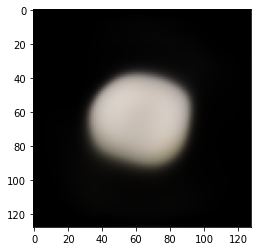

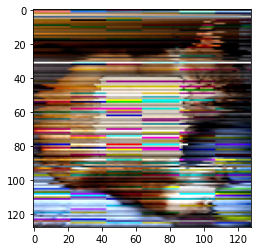

In [28]:
#torch.save(model, "train_b8.pth")

image,_ = img_files[0]

res = model(image.reshape(1,3,128,128).cuda())

img = res[0].detach().cpu().permute((1,2,0))

plt.imshow(img)
plt.show()
plt.imshow(image.permute((1,2,0)))